In [1]:
import re
import string
import pickle
import requests
import shortuuid
import dill as pickle
import networkx as nx
from dateutil import parser
from datetime import datetime
from bs4 import BeautifulSoup
from pyvis.network import Network
from IPython.display import clear_output

# This is a cool library that I found! It should make the bibliography a little more interesting.
from summa.summarizer import summarize

In [ ]:
REFERENCES = 'references.pkl'
INVALID_REFERENCE_NAMES = ['Google', 'google', 'CrossRef']
MAX_NODES = 100
ALPHABET = string.digits + string.ascii_letters
UID_GENERATOR = shortuuid.ShortUUID(alphabet=ALPHABET)

In [3]:
class Reference:
    def __init__(self, link: str, title: str = None, date: datetime = None):
        self.title = title
        self.date = date.date().isoformat()
        self.link = link
        self.node_id = create_node_id()
        self.citations = []
        self.summary = None

    def scrape_citations(self):
        return [scrape_references(c) for c in self.citations]
        
    def filter_citations(self):
        self.citations = [c for c in self.citations if all(substring not in c.title for substring in INVALID_REFERENCE_NAMES)]
        self.citations = [c for c in self.citations if c.date]
    
    def __repr__(self):
        return f"{self.node_id} {self.date}"


def create_node_id():
    return UID_GENERATOR.random(length=5)


def save_references(ref_list: list[Reference]):
    with open(REFERENCES, 'wb') as f:
        pickle.dump(ref_list, f)


def load_references(loc: str = REFERENCES):
    try:
        with open(loc, 'rb') as f:
            ref_list = pickle.load(f)
        return ref_list
    except:
        return None


reference_list: list[Reference] = []

<div class="alert alert-block alert-warning">
    <b>AI GENERATED CODE BELOW:</b> The scrape_references() code was generated using Gemini 3.0. <br>
    It's relatively straightforward: We look at a given webpage and return it's outward links if it has a references/bibliography section.
    
    https://gemini.google.com/share/39bd782e03c2
</div>

Note that this generated code was actually pretty sloppy and needed significant modifications. I altered the logic more than anything, but generally left its regex matching and html requests unchanged.

In [ ]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

INSTRUCTIONS = """
Summarize the paper copied below in a single sentence if possible. 
If you do not see enough content to generate a summary, please return a summary of the title.
Return no other text except for the summary. Return only a single, concise sentence in your response. 
"""

def create_prompt(web_page_content: str):
    prompt = f"""
        {INSTRUCTIONS}
        {web_page_content}
    """
    return prompt

def get_summary(prompt, model="gpt-5-nano-2025-08-07"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(        
        model=model, messages=messages)
    return response.choices[0].message.content

In [5]:
def scrape_references(ref: Reference):
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    headers = {"User-Agent": user_agent}

    url = ref.link
    references = []

    try:
        clear_output(wait=True)
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.RequestException as e: 
        print(f"Error with {url}: {e}")
        return 

    soup = BeautifulSoup(response.text, 'html.parser')
    content = soup.text[:1000]
    ref.summary = get_summary(content)

    # Anthony comment here:
    # I encountered a lot of Google Scholar and Cross Ref links. By default, they all get that title,
    # But while we're looking in their html, let's try to fix their names!
    title = ref.title
    if any([substring in title for substring in INVALID_REFERENCE_NAMES]):
        # Priority 1: Academic & Social Meta Tags
        title_meta = soup.find("meta", {"name": "citation_title"}) or \
                     soup.find("meta", {"property": "og:title"})
        
        if title_meta:
            title = title_meta.get("content")
        
        # Priority 2: Standard HTML <title> tag
        if not title and soup.title:
            title = soup.title.string
            
        # Priority 3: First <h1> tag
        if not title:
            h1 = soup.find("h1")
            if h1:
                title = h1.get_text(strip=True)
    
        # Clean up title: remove extra whitespace or newlines
        title = " ".join(title.split()) if title else "Unknown Title"
        ref.title = title

    # Another Anthony comment here:
    # The regex below does a terrible job at finding the correct publication date. So, once we visit the page, I update the date here.
    if soup:
        ref.date = find_publication_date(soup)
    
    # 1. Locate the Reference Section
    ref_section = soup.find(['div', 'section'], id=re.compile(r'ref|bib|bibliography|references', re.I))
    
    if not ref_section:
        header = soup.find(['h1', 'h2', 'h3'], string=re.compile(r'References|Bibliography', re.I))
        if header:
            ref_section = header.find_parent()
        else:
            # If no section is found, we search the whole soup
            ref_section = soup

    # 2. Find all links specifically containing 'doi.org'
    # This finds <a> tags where the href attribute matches the DOI pattern
    doi_links = ref_section.find_all('a', href=re.compile(r'doi\.org', re.I))

    for link_tag in doi_links:
        link = link_tag['href']
        
        # Ensure the link is absolute
        if link.startswith('/'):
            link = requests.compat.urljoin(url, link)

        # 3. Extract Contextual Information
        # We look at the parent element (likely an <li> or <p>) to get the full citation text
        parent_context = link_tag.find_parent(['li', 'p', 'div'])
        text = parent_context.get_text(separator=" ", strip=True) if parent_context else link_tag.get_text()

        # Name/Title: Use the first 100 chars of the citation text as a label
        name = text[:100] + "..." if len(text) > 100 else text
        
        # Date: Look for a 4-digit year (19xx or 20xx)
        date_match = re.search(r'\b(19|20)\d{2}\b', text)
        if date_match:
            try:
                pub_date = datetime(int(date_match.group()), 1, 1)
            except ValueError:
                pub_date = datetime.now()
        else:
            pub_date = datetime.now() 

        # 4. Create the Reference Object
        references.append(Reference(title=name, date=pub_date, link=link))
        ref.citations = references

    return references


def find_publication_date(soup):
    """
    Finds the publication date and returns it in ISO 8601 format (YYYY-MM-DD).
    """
    raw_date = None

    # 1. Search Meta Tags
    date_attributes = [
        # Google Scholar & HighWire Press (Very common)
        "citation_date", "citation_publication_date", "citation_online_date",
        
        # Dublin Core (Standard for institutional repositories)
        "dc.date", "dc.date.issued", "dc.date.available", "dc.date.created",
        "DCTERMS.issued", "DCTERMS.available",
        
        # PRISM (Used by many journals)
        "prism.publicationDate", "prism.coverDate",
        
        # OpenGraph & General SEO (Nature, Frontiers, MDPI)
        "article:published_time", "article:modified_time", "pubdate",
        "publication_date", "date", "sailthru.date",
        
        # Site-specific (e.g., Elsevier/ScienceDirect)
        "citation_cover_date", "og:published_time"
    ]
    
    for attr in date_attributes:
        meta_tag = soup.find("meta", attrs={"name": attr}) or \
                   soup.find("meta", attrs={"property": attr})
        if meta_tag and meta_tag.get("content"):
            raw_date = meta_tag["content"].strip()
            break

    # 2. Fallback to <time> tag
    if not raw_date:
        time_tag = soup.find("time")
        if time_tag:
            raw_date = time_tag.get("datetime") or time_tag.get_text().strip()

    # 3. Fallback to Regex
    if not raw_date:
        date_pattern = re.compile(r'(\d{4}[-/]\d{2}[-/]\d{2})|(\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4})', re.IGNORECASE)
        match = date_pattern.search(soup.get_text())
        if match:
            raw_date = match.group(0)
        # Year only with context: © 2023 or Published: 2023

    # --- Convert to ISO Format ---
    if raw_date:
        try:
            # fuzzy=True allows it to ignore extra text around the date
            dt = parser.parse(raw_date, fuzzy=True)
            return dt.date().isoformat()
        except (ValueError, OverflowError):
            return None

    return None

# Starting the assignment

Sean Taylor's video will be our starting point. We'll start off by watching the video, making sure to add all of his references that we see as he goes through his presentation.

In [6]:
# Sean's video
video = Reference(
    title="Causal Forecacsting",
    date=datetime(2022, 12, 9),
    link="https://www.youtube.com/watch?v=JGkfbRKuZkI"
)

And now for the tweets/books/etc that Sean references in his presentation...

In [7]:
# We see a source for a plot at ~8:50 along the bottom of the screen.
griffith_tweet = Reference(
    title="Gareth Griffith Tweet",
    date=datetime(2020, 11, 12),
    link="https://x.com/Garethjgriffith/status/1326935579871817728"
)

# His tweet links to his nature article. We'll add that too. This will be our starting point when we start scraping references.
griffith_paper = Reference(
    title="Collider bias undermines our understanding of COVID-19 disease risk and severity",
    date=datetime(2020, 11, 12),
    link="https://www.nature.com/articles/s41467-020-19478-2#Bib1"
)

# We also see the following references at 34 minutes into the video
lyft_1 = Reference(
    title='Causal Forecasting at Lyft (Part 1)',
    date=datetime(2022, 6, 28),
    link='https://eng.lyft.com/causal-forecasting-at-lyft-part-1-14cca6ff3d6d'
)

lyft_2 = Reference(
    title='Causal Forecasting at Lyft (Part 2)',
    date=datetime(2022, 8, 25),
    link='https://eng.lyft.com/causal-forecasting-at-lyft-part-2-418f1febca5a'
)

book_of_why = Reference(
    title='The Book of Why',
    date=datetime(2018, 5, 1),
    link='http://repo.darmajaya.ac.id/5342/1/The%20book%20of%20why_%20the%20new%20science%20of%20cause%20and%20effect%20%28%20PDFDrive%20%29.pdf'
)

morgan_winship = Reference(
    title='Counterfactuals and Causal Inference',
    date=datetime(2014, 12, 5),
    link='https://www.cambridge.org/core/books/counterfactuals-and-causal-inference/5CC81E6DF63C5E5A8B88F79D45E1D1B7'
)

And while we're at it, let's add the references above to the list of video citations. These will become our directed edges in our citation network.

In [8]:
video.citations = [griffith_tweet, lyft_1, lyft_2, book_of_why, morgan_winship]
griffith_tweet.citations = [griffith_paper]

Ok! Enough of that. Let's use my modified AI slop web scraper to build the rest, starting with the two papers with references.

<div class="alert alert-block alert-info">
This web scraper misses a lot of good reference links and improperly handles errors, but I don't think fixing those issues are within the scope of this assignment.

<b>My main line of effort for this assignment is learning how to build a directed network diagram.</b>
</div>

I will briefly describe how this process works though:
1. We start with a list of Reference class objects (defined above).
2. We grab the raw html of that web page and search (using modified AI generated code) for the resources that they have cited.
3. We attempt to visit the web page for each citation link found in step 2. Lots of errors happen here, but we generally ignore them(403, 404, etc.). All of the good references get stored in the citations attribute of our Reference class instance. They're assigned a random 5 character alphanumeric identifier here. <b> I don't attempt to check for unique identifier collisions here </b> (but we're not building production level code here).
4. When we visit each web page, we usually have access to better information about that source. We update the paper's title or publication date as we visit them.
5. If we encounter an error or find a reference that doesn't seem to have a better name than "Google Scholar" or a better date than new years day, then we just remove it. The last thing I want to do is build a network of nodes named "Google Scholar" and "CrossRef" all published on Jan 1, 2020. It looks like we still get a bunch of January 1st papers sneaking through.

# A quick test!

Here, we're just checking that everything works. We're getting some error messages, but that's alright. Not every website is going to let us in or have any valid links (they might not even be there anymore!).

We only get a couple valid references from the Morgan and Winship paper, but each one of these will probably lead us to some more papers. I think we're looking good!

In [9]:
for ref in [morgan_winship]:
    scrape_references(ref)
    ref.scrape_citations()
    ref.filter_citations()

Error with https://doi.org/10.2139/ssrn.2728512: 403 Client Error: Forbidden for url: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2728512


In [10]:
morgan_winship.citations[2].summary

'It looks like you’re pointing to a BMC Public Health article titled “Causal inference in multi-state models–sickness absence and work for 1145 participants after work rehabilitation” (open access, published Oct 23, 2015). If you want, I can help with a summary, explanation of the methods, or help you reproduce or interpret the analysis. Right now I don’t have the article text in front of me, so I can’t quote specific findings. Here are a few ways I can assist:\n\nWhat I can provide right away\n- A plain-language explanation of the likely methods and goals:\n  - Multi-state models: These models track individuals as they move between different states over time (e.g., working full-time, on sickness absence, on partial absence, returning to work, etc.). They estimate transition intensities (hazards) for moving from one state to another.\n  - Causal inference in this setting: When using observational data (like after a work rehabilitation program), there may be time-varying confounders tha

In [11]:
morgan_winship.summary

'It looks like you opened a Cambridge Core page titled “Counterfactuals and Causal Inference.” Do you want a primer, a summary of key ideas, or help with a specific method or chapter? Here’s a compact overview to get you started.\n\nWhat counterfactuals are\n- A counterfactual describes what would have happened to the same unit if a different action or treatment had been taken (e.g., “If I had taken the medicine, my outcome would have improved.”).\n- Causal inference aims to estimate these counterfactual effects from observed data.\n\nTwo main theoretical frameworks\n- Rubin Causal Model (Potential Outcomes):\n  - Each unit has potential outcomes under each treatment level (Y(1), Y(0)).\n  - The causal effect is the contrast, e.g., Y(1) − Y(0) for the unit; average causal effect is E[Y(1) − Y(0)].\n- Pearl’s Structural Causal Models and DAGs:\n  - Represent causal relationships with directed acyclic graphs and use interventions (do-operator) to formalize counterfactuals.\n  - Do-calcul

# The Big One

My web scraper is horribly inefficient. It actually took about <b>24 hours</b> to crawl through the first 1000 papers. The network returned was too big for me to really display through html.

But in the end, I saved the output to a .pkl file which can be checked before we ever enter the loop. If that file ever got deleted, then we can rerun the code below, but now I can safely close my notebook without having to run the recursive graph-building process over again.

In [12]:
adj_list = load_references()

In [13]:
if not adj_list:
    adj_list = {}
    
    # Let's not forget these! These are the references that we manually entered above
    adj_list[video] = [n for n in video.citations]
    adj_list[griffith_tweet] = [griffith_paper]
    
    start_nodes = [griffith_paper, morgan_winship]
    
    visited_refs = set()
    queue = start_nodes
    
    while queue and len(visited_refs) < MAX_NODES:
        ref = queue.pop(0)
        
        if ref in visited_refs:
            continue
            
        scrape_references(ref)
        ref.scrape_citations()
        ref.filter_citations()
        
        visited_refs.add(ref)
        adj_list[ref] = [cite for cite in ref.citations]
        
        for cite in ref.citations:
            if cite not in visited_refs:
                queue.append(cite)

save_references(adj_list)

Error with https://doi.org/10.1002/sim.3172: 403 Client Error: Forbidden for url: https://onlinelibrary.wiley.com/doi/10.1002/sim.3172


# Building the Graph

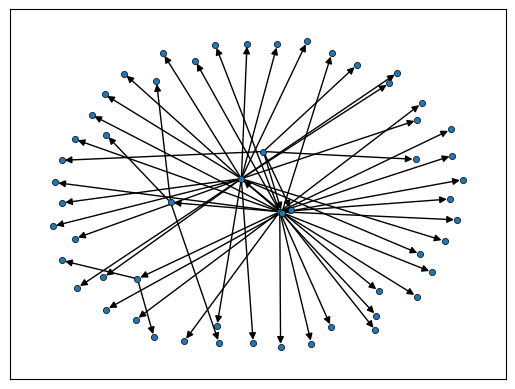

In [14]:
G = nx.DiGraph(adj_list)
nx.draw_networkx(G, edgecolors='black', node_size=20, linewidths=0.5, with_labels=False)

Well, I should have expected this. This looks horrible.

But I do have some prior experience with Pyvis, so let's us that for some interactive plots. This will launch a browser window and begin loading the index.html file.

In [19]:
net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", directed=True)
out_degree = dict(G.out_degree())

# Adding nodes
for node_ref in G.nodes():
    
    # Adding hover over text
    hover_text = (
        f"<b>Title:</b> {node_ref.title}<br>"
        f"<b>Date:</b> {node_ref.date}<br>"
        f"<b>Link:</b> <a href='{node_ref.link}'>Source</a><br>"
        f"<b>References:</b> {out_degree.get(node_ref, 'UNK')} Papers<br>"
        f"<b>Summary:</b> {str(node_ref.summary)[:100]}...<br>"
    )

    # I thought this would be a nice touch: We'll turn our video node bright red and easy to find!
    if node_ref.title == video.title:
            node_color = "orangered"  
            node_size = 50     
    else:
        node_color = "cornflowerblue"
        node_size = out_degree.get(node_ref, 0) * 2 + 15

    net.add_node(node_ref.node_id, 
                 label=node_ref.node_id, 
                 size=node_size,
                 title=hover_text,
                 color=node_color
                )

# Edges
for source, target in G.edges():
    net.add_edge(source.node_id, target.node_id, color="#abb2b9")

# Displaying
net.force_atlas_2based()
net.show_buttons()
net.show("index.html", notebook=False)

index.html


# Building Our Annotated Bibliography